In [1]:
import os
os.chdir("C:/Users/ibo.kylegregory/bisaya-stt-module")


In [2]:
import os
import pandas as pd
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

# Path to metrics and logs
metrics_file = "docs/validation_metrics.md"
loss_log = "logs/loss_history.csv"


In [3]:
def show_latest_wer():
    if not os.path.exists(metrics_file):
        display(Markdown("⚠️ `validation_metrics.md` not found yet."))
        return
    with open(metrics_file, "r", encoding="utf-8") as f:
        lines = f.readlines()
        if not lines:
            display(Markdown("🟡 No WER data yet."))
            return
        display(Markdown("### 🧾 Latest WER Metrics"))
        display(Markdown("```\n" + "".join(lines[-5:]) + "\n```"))

show_latest_wer()


### 🧾 Latest WER Metrics

```
2025-07-19T14:28:57.764888 - WER: 1.0000
2025-07-19T14:51:05.242947 - WER: 1.0000
2025-07-19T15:13:15.705496 - WER: 1.0000
2025-07-19T15:50:14.442783 - WER: 1.0000
2025-07-19T16:12:33.337858 - WER: 1.0000

```

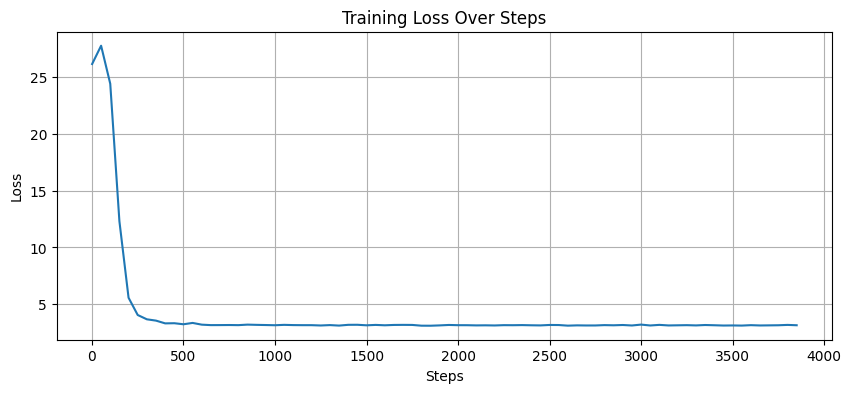

In [4]:
def plot_loss():
    if not os.path.exists(loss_log):
        display(Markdown("⚠️ `loss_history.csv` not found yet."))
        return
    df = pd.read_csv(loss_log)
    if df.empty:
        display(Markdown("🟡 No loss data yet."))
        return
    plt.figure(figsize=(10, 4))
    plt.plot(df["step"], df["loss"])
    plt.title("Training Loss Over Steps")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

plot_loss()


In [5]:
TRAIN_SIZE = 3080  # adjust based on your dataset['train'] count
BATCH_SIZE = 1
GRAD_ACCUM = 4

STEPS_PER_EPOCH = (TRAIN_SIZE + (BATCH_SIZE * GRAD_ACCUM) - 1) // (BATCH_SIZE * GRAD_ACCUM)


In [6]:
import os
import re
import time
from IPython.display import clear_output, display

CHECKPOINT_DIR = "models/wav2vec2/v1_bisaya"
POLL_INTERVAL = 60  # in seconds

def get_latest_checkpoint(path=CHECKPOINT_DIR):
    if not os.path.exists(path):
        return None

    checkpoint_steps = []
    for d in os.listdir(path):
        match = re.match(r"checkpoint-(\d+)", d)
        if match:
            checkpoint_steps.append(int(match.group(1)))
    return max(checkpoint_steps) if checkpoint_steps else None


In [7]:
def monitor_training_progress(interval=POLL_INTERVAL, patience_minutes=10):
    print("📡 Monitoring training progress...")
    history = []
    last_step = None
    stagnant_counter = 0
    max_stagnant_checks = patience_minutes * 60 // interval

    while True:
        clear_output(wait=True)
        current_step = get_latest_checkpoint()

        if current_step is None:
            print("❌ No checkpoints found.")
        else:
            timestamp = time.strftime('%Y-%m-%d %H:%M:%S')
            estimated_epoch = current_step / STEPS_PER_EPOCH
            print(f"[{timestamp}] ✅ Checkpoint step: {current_step}")
            print(f"📊 Estimated epoch: {estimated_epoch:.2f}")
            history.append((timestamp, current_step, estimated_epoch))

            if last_step == current_step:
                stagnant_counter += 1
                print(f"⚠️ No new checkpoints. Stagnant for {stagnant_counter * interval} seconds.")
                if stagnant_counter >= max_stagnant_checks:
                    print("🚨 Training may have stopped. No progress detected.")
                    break
            else:
                stagnant_counter = 0

            last_step = current_step

        time.sleep(interval)


In [ ]:
monitor_training_progress(interval=300, patience_minutes=10)


[2025-07-19 17:30:09] ✅ Checkpoint step: 3000
📊 Estimated epoch: 3.90
⚠️ No new checkpoints. Stagnant for 300 seconds.


In [ ]:
from transformers import Wav2Vec2Processor
from datasets import load_from_disk
import torch

# Constants
DATASET_VERSION = "v1_training_ready_grapheme"
PROCESSOR_VERSION = "v1_grapheme"
MAX_INPUT_LENGTH_SEC = 15

# === Load your processor ===
processor = Wav2Vec2Processor.from_pretrained(
    r"C:\Users\ibo.kylegregory\bisaya-stt-module\processor\v1_grapheme",
    local_files_only=True
)

# === Load dataset ===
raw_dataset = load_from_disk(r"C:\Users\ibo.kylegregory\bisaya-stt-module\data\processed\v1_training_ready_grapheme")
max_len = int(processor.feature_extractor.sampling_rate * MAX_INPUT_LENGTH_SEC)
filtered_dataset = raw_dataset.filter(lambda x: len(x["input_values"]) <= max_len)
dataset = filtered_dataset["train"].train_test_split(test_size=0.1)

# === Sample: Inspect a label sequence ===
sample = dataset["test"][0]  # or adjust index
label_ids = sample["labels"]

# === Convert label IDs to tokens ===
tokens = processor.tokenizer.convert_ids_to_tokens(label_ids)
decoded_text = processor.tokenizer.decode(label_ids, skip_special_tokens=True)

print("🔢 Label IDs:", label_ids)
print("🔡 Tokens:", tokens)
print("📝 Decoded Text:", decoded_text)


In [ ]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
from datasets import load_from_disk
import torch
import os

# === Constants ===
MODEL_PATH = "models/wav2vec2/v1_bisaya"
PROCESSOR_PATH = "processor/v1_grapheme"
DATASET_PATH = "data/processed/v1_training_ready_grapheme"
MAX_INPUT_LENGTH_SEC = 15

# === Load model and processor ===
processor = Wav2Vec2Processor.from_pretrained(PROCESSOR_PATH, local_files_only=True)
model = Wav2Vec2ForCTC.from_pretrained(MODEL_PATH, local_files_only=True)
model.eval()

# === Load dataset and sample ===
raw_dataset = load_from_disk(DATASET_PATH)
max_len = int(processor.feature_extractor.sampling_rate * MAX_INPUT_LENGTH_SEC)
filtered_dataset = raw_dataset.filter(lambda x: len(x["input_values"]) <= max_len)
dataset = filtered_dataset["train"].train_test_split(test_size=0.1)

sample = dataset["test"][0]
input_values = torch.tensor([sample["input_values"]])
attention_mask = torch.ones_like(input_values)

# === Predict ===
with torch.no_grad():
    logits = model(input_values).logits

pred_ids = torch.argmax(logits, dim=-1)[0]
pred_tokens = processor.tokenizer.convert_ids_to_tokens(pred_ids)
pred_text = processor.batch_decode(pred_ids.unsqueeze(0))[0]

# === Decode reference ===
ref_text = processor.tokenizer.decode(sample["labels"], skip_special_tokens=True)

# === Output ===
print("📌 Reference Text:", ref_text)
print("🎯 Predicted IDs:", pred_ids.tolist())
print("🔡 Predicted Tokens:", pred_tokens)
print("🧠 Predicted Text:", pred_text)


In [ ]:
from transformers import Wav2Vec2Processor

# Adjust path as needed
processor_path = "./processor/v1_grapheme"
processor = Wav2Vec2Processor.from_pretrained(processor_path)

print("✅ Processor loaded from:", processor_path)
print("🔠 Vocab size:", len(processor.tokenizer))


In [ ]:
# Simulate a Trainer prediction step
from torch.nn.functional import softmax

logits = torch.tensor(pred.predictions)
pred_ids = torch.argmax(logits, dim=-1)[0]

print("🧠 Raw Predicted IDs:", pred_ids.tolist())
print("🔡 Tokens:", processor.tokenizer.convert_ids_to_tokens(pred_ids))
print("📝 Decoded:", processor.batch_decode([pred_ids])[0])
